In [1]:
from pulp import *
import networkx as nx
import pandas as pd
import numpy as np
import os

In [2]:
!ls data

factory_to_warehouse.xlsx


In [3]:
file = os.path.join('data','factory_to_warehouse.xlsx')

In [4]:
factories = pd.read_excel(file, sheetname='Factories')
warehouses = pd.read_excel(file, sheetname='Warehouses')
lanes = pd.read_excel(file, sheetname='Lanes')

In [5]:
factories.head()

,Factory,Supply
0,Garfield,150
1,Odie,225
2,Pikachu,200
3,Walter,100


In [6]:
warehouses.head()

,Warehouse,Demand
0,SuperStore,50
1,Woolmart,100
2,Starbucklers,50
3,Castco,125
4,McRonalds,100


In [7]:
lanes.head()

,origin,destination,cost,capacity
0,Garfield,SuperStore,1.26,122
1,Garfield,Woolmart,1.69,36
2,Garfield,Starbucklers,1.31,29
3,Garfield,Castco,1.64,78
4,Garfield,McRonalds,1.41,72


In [8]:
#check that we have a solveable problem
assert factories.Supply.sum() >= warehouses.Demand.sum()

In [9]:
#check that each warehouse can be serviced
#ie the total capacity for lanes into the warehouse should meet or exceed the demand
capacity_in = lanes.groupby('destination').capacity.sum()
check = warehouses.set_index('Warehouse').join(capacity_in)
assert np.all(check.capacity >= check.Demand)

#also need that for the lanes available, the supply, up to capacity, can satsify the demand
#TODO later

In [10]:
#make a network

In [11]:
G = nx.DiGraph()

In [12]:
#add all the nodes
for i, row in factories.iterrows():
    G.add_node(row.Factory, supply=row.Supply, node_type='factory')
    
for i, row in warehouses.iterrows():
    G.add_node(row.Warehouse, demand=row.Demand, node_type='warehouse')

In [13]:
for i, row in lanes.iterrows():
    G.add_edge(row.origin, row.destination, cost=row.cost, capacity=row.capacity)

In [14]:
%matplotlib inline

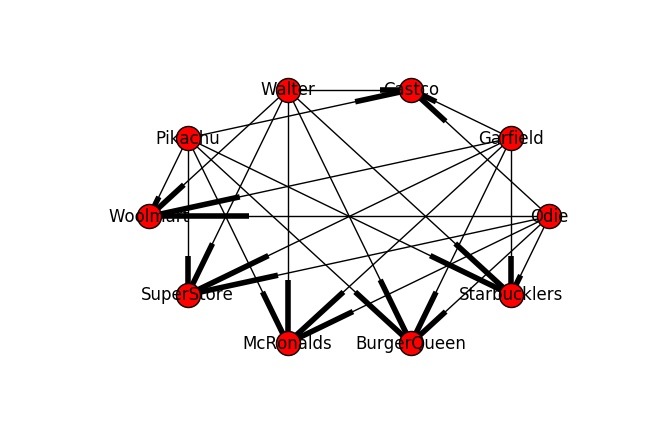

In [15]:
layout = nx.layout.circular_layout(G)
nx.draw(G,layout)
nx.draw_networkx_labels(G,layout);

In [16]:
#the variables are the amounts to put on each edge
#LpVariale.dicts allows us to access the variables using dictionary access syntax
# ie the quantity from Garfield to BurgerQueen is qty[('Garfield','BurgerQueen)]
# the actual variable name created under the hood is qty_('Garfield',_'BurgerQueen')
qty = LpVariable.dicts("qty", G.edges(), lowBound=0)

In [17]:
#the objective

In [18]:
#the total cost of this routing is the cost per unit * the qty sent on each lane
def objective():
    shipping_cost = lpSum([ qty[(org,dest)]*data['cost'] for (org,dest,data) in G.edges(data=True)])
    return shipping_cost

In [20]:
def constraints():
    #constraints
    #make sure we satisfy the demand at each warehouse
    #that means the sum of all the qty inbound to the warehouse must be equal to the demand
    #networkx makes this very easy to program because we can simply ask for all the inbound edges to a given node using .in_edges
    
    constraints=[]
    
    for x, data in G.nodes(data=True):
        #demand must be met
        if data['node_type'] =='warehouse':
            inbound_qty = lpSum([ qty[(org,x)] for org, _ in G.in_edges(x)])
            c = inbound_qty == data['demand']
            constraints.append(c)
        #must not use more than the available supply
        elif data['node_type'] =='factory':
            out_qty = lpSum([ qty[(x,dest)] for _,dest in G.out_edges(x)])
            c = out_qty <= data['supply']
            constraints.append(c)
            
    #now the edge constraints
    #we qty <= capacity on each lane
    for org,dest, data in G.edges(data=True):
        c = qty[(org,dest)] <= data['capacity']
        constraints.append(c)
        
    return constraints

In [21]:
#setup the problem
prob = LpProblem('warehouse_routing',LpMinimize)

In [22]:
prob += objective()

In [23]:
for c in constraints():
    prob+=c

In [24]:
prob.solve()

1

In [25]:
value(prob.objective)

799.95

In [27]:
#you can also use the value() function instead of .varValue
for org,dest in G.edges():
    v= value(qty[(org,dest)])
    if v >0:
        print(org,dest, v)

Odie Castco 47.0
Odie Woolmart 38.0
Odie BurgerQueen 30.0
Odie Starbucklers 50.0
Garfield McRonalds 43.0
Garfield Castco 52.0
Garfield SuperStore 50.0
Garfield BurgerQueen 5.0
Walter Castco 26.0
Pikachu McRonalds 57.0
Pikachu Woolmart 62.0
Pikachu BurgerQueen 40.0


In [28]:
lanes.head()

,origin,destination,cost,capacity
0,Garfield,SuperStore,1.26,122
1,Garfield,Woolmart,1.69,36
2,Garfield,Starbucklers,1.31,29
3,Garfield,Castco,1.64,78
4,Garfield,McRonalds,1.41,72


In [31]:
#lets verify all the conditions
#first lets stuff our result into a dataframe for export
result=[]
for org,dest in G.edges():
    v= value(qty[(org,dest)])
    result.append({'origin':org,'destination':dest,'qty':v})
result_df = pd.DataFrame(result)

In [35]:
lanes['key']=lanes.origin+lanes.destination
result_df['key'] = result_df.origin+result_df.destination

In [39]:
lanes = lanes.set_index('key').merge(result_df.set_index('key'))

In [45]:
#any lane over capacity
assert np.all(lanes.qty <= lanes.capacity)

In [52]:
#check that we met the demand
out_qty =lanes.groupby('destination').qty.sum()
check = warehouses.set_index('Warehouse').join(out_qty)
assert np.all(check.qty == check.Demand)


In [57]:
#check that we met the supply
in_qty =lanes.groupby('origin').qty.sum()
check = factories.set_index('Factory').join(in_qty)
assert np.all(check.qty <= check.Supply)


In [59]:
#the result!
lanes

,origin,destination,cost,capacity,qty
0,Garfield,SuperStore,1.26,122,50.0
1,Garfield,Woolmart,1.69,36,0.0
2,Garfield,Starbucklers,1.31,29,0.0
3,Garfield,Castco,1.64,78,52.0
4,Garfield,McRonalds,1.41,72,43.0
5,Garfield,BurgerQueen,1.78,86,5.0
6,Odie,SuperStore,2.12,106,0.0
7,Odie,Woolmart,1.41,91,38.0
8,Odie,Starbucklers,1.34,77,50.0
9,Odie,Castco,1.91,47,47.0
